Lab Exercise 9:
Machine Translation using RNN, LSTM, and Bi-LSTM

1. Implement a Neural Machine Translation (NMT) system using RNN, LSTM, and Bi-
LSTM. Train your model on a small parallel dataset (e.g., English-to-Kannada or English-
to-Hindi, Any Language to Any Langugae ). Compare the performance of these three

models.
2. Evaluate the quality of translations using BLEU Score and Perplexity.
3. Implement and analyze the difference in translation accuracy when using teacher
forcing versus without teacher forcing in training RNN-based models.
Questions:
1. What is the difference between RNN, LSTM, and Bi-LSTM in the context of Machine
Translation?
2. Why is LSTM preferred over vanilla RNNs for sequence-to-sequence tasks?
3. How does the bidirectional nature of Bi-LSTM improve translation accuracy?
4. What is teacher forcing, and how does it impact training in sequence-to-sequence
models?
5. Explain how BLEU score is calculated and its significance in evaluating translation
quality.

In [3]:
import pandas as pd


df = pd.read_csv('/content/eng_-french.csv')


df = df.rename(columns={'English words/sentences': 'english', 'French words/sentences': 'french'})


df.head()


,english,french
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
 print(df.columns)

Index(['english', 'french'], dtype='object')


In [5]:
df = df.dropna(subset=['english', 'french'])


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, cell_type='rnn'):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        if cell_type == 'rnn':
            self.rnn = tf.keras.layers.SimpleRNN(units, return_sequences=True, return_state=True)
        elif cell_type == 'lstm':
            self.rnn = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
        elif cell_type == 'bilstm':
            self.rnn = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(units, return_sequences=True, return_state=True),
                merge_mode='concat'
            )

    def call(self, x):
        x = self.embedding(x)
        output = self.rnn(x)
        return output


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, cell_type='rnn'):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        if cell_type == 'rnn':
            self.rnn = tf.keras.layers.SimpleRNN(units, return_sequences=True, return_state=True)
        elif cell_type == 'lstm':
            self.rnn = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
        elif cell_type == 'bilstm':
            self.rnn = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(units, return_sequences=True, return_state=True),
                merge_mode='concat'
            )
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, enc_output):
        x = self.embedding(x)
        x = self.rnn(x)[0]
        x = self.fc(x)
        return x


In [ ]:
def train_model(cell_type='rnn', epochs=2):
    embedding_dim = 64
    units = 128

    encoder = Encoder(inp_vocab_size, embedding_dim, units, cell_type)
    decoder = Decoder(targ_vocab_size, embedding_dim, units, cell_type)

    # Model definition
    input_seq = tf.keras.Input(shape=(None,))
    target_seq = tf.keras.Input(shape=(None,))

    enc_output, *_ = encoder(input_seq)
    dec_output = decoder(target_seq, enc_output)

    model = tf.keras.Model(inputs=[input_seq, target_seq], outputs=dec_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        [input_train, target_train[:, :-1]],
        target_train[:, 1:][..., np.newaxis],
        validation_data=(
            [input_val, target_val[:, :-1]],
            target_val[:, 1:][..., np.newaxis]
        ),
        batch_size=64,
        epochs=epochs,
        verbose=1
    )

    print(f"{cell_type.upper()} model training complete.")
    return model, history


In [ ]:

df = df[['french', 'english']].dropna()
df['french'] = df['french'].apply(lambda x: '<start> ' + x.strip() + ' <end>')
df['english'] = df['english'].apply(lambda x: x.strip())

# 2. Tokenization
def tokenize(texts):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=True)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')
    return padded, tokenizer

input_tensor, inp_tokenizer = tokenize(df['english'])  # English is input
target_tensor, targ_tokenizer = tokenize(df['french'])  # French is target

# 3. Vocab sizes (✅ make these GLOBAL so train_model() can access them)
inp_vocab_size = len(inp_tokenizer.word_index) + 1
targ_vocab_size = len(targ_tokenizer.word_index) + 1

# 4. Train/test split
from sklearn.model_selection import train_test_split
input_train, input_val, target_train, target_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2
)




In [ ]:
rnn_model, rnn_hist = train_model('rnn')
lstm_model, lstm_hist = train_model('lstm')
bilstm_model, bilstm_hist = train_model('bilstm')


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['encoder_2/embedding_4/embeddings', 'encoder_2/simple_rnn_4/simple_rnn_cell/kernel', 'encoder_2/simple_rnn_4/simple_rnn_cell/recurrent_kernel', 'encoder_2/simple_rnn_4/simple_rnn_cell/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 215s 95ms/step - accuracy: 0.8327 - loss: 1.8857 - val_accuracy: 0.8476 - val_loss: 1.7359
Epoch 2/2
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 254s 93ms/step - accuracy: 0.8475 - loss: 1.6698 - val_accuracy: 0.8463 - val_loss: 1.6743
RNN model training complete.
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['encoder_3/embedding_6/embeddings', 'encoder_3/lstm/lstm_cell/kernel', 'encoder_3/lstm/lstm_cell/recurrent_kernel', 'encoder_3/lstm/lstm_cell/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 569s 256ms/step - accuracy: 0.8767 - loss: 1.3386 - val_accuracy: 0.8930 - val_loss: 1.1613
Epoch 2/2
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 617s 256ms/step - accuracy: 0.8926 - loss: 1.1637 - val_accuracy: 0.8763 - val_loss: 1.3362
LSTM model training complete.
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['encoder_4/embedding_8/embeddings', 'encoder_4/bidirectional/forward_lstm_2/lstm_cell/kernel', 'encoder_4/bidirectional/forward_lstm_2/lstm_cell/recurrent_kernel', 'encoder_4/bidirectional/forward_lstm_2/lstm_cell/bias', 'encoder_4/bidirectional/backward_lstm_2/lstm_cell/kernel', 'encoder_4/bidirectional/backward_lstm_2/lstm_cell/recurrent_kernel', 'encoder_4/bidirectional/backward_lstm_2/lstm_cell/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 692s 314ms/step - accuracy: 0.1234 - loss: 9.5314 - val_accuracy: 0.1340 - val_loss: 9.3259
Epoch 2/2
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 734s 310ms/step - accuracy: 0.1338 - loss: 9.3243 - val_accuracy: 0.1371 - val_loss: 9.2771
BILSTM model training complete.


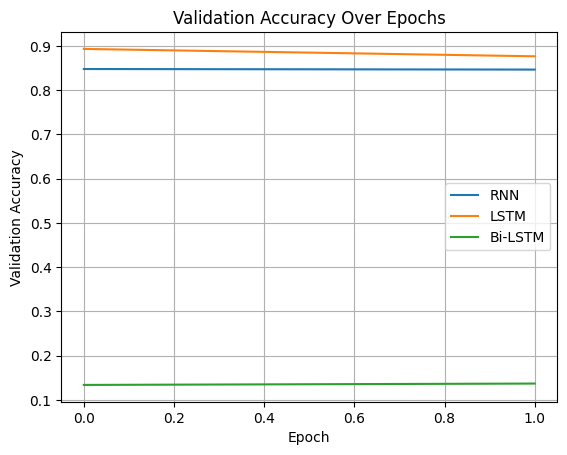

In [ ]:
import matplotlib.pyplot as plt

def plot_histories(histories, labels):
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_accuracy'], label=label)
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histories([rnn_hist, lstm_hist, bilstm_hist], ['RNN', 'LSTM', 'Bi-LSTM'])


In [ ]:
# Reverse tokenizer maps
reverse_target_index = {idx: word for word, idx in targ_tokenizer.word_index.items()}
reverse_target_index[0] = ''

def sequence_to_text(sequence):
    return ' '.join([reverse_target_index.get(idx, '') for idx in sequence]).strip()


In [ ]:
def predict_translation(model, input_seq, max_len=20):
    enc_input = tf.expand_dims(input_seq, axis=0)
    dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']], axis=0)

    result = []

    for _ in range(max_len):
        predictions = model.predict([enc_input, dec_input], verbose=0)
        predicted_id = tf.argmax(predictions[0, -1, :]).numpy()
        if predicted_id == targ_tokenizer.word_index['<end>']:
            break
        result.append(predicted_id)
        dec_input = tf.concat([dec_input, [[predicted_id]]], axis=-1)

    return sequence_to_text(result)


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_bleu(model, num_samples=100):
    smoothie = SmoothingFunction().method4
    bleu_scores = []

    for i in range(num_samples):
        input_seq = input_val[i]
        target_seq = target_val[i]

        reference = [sequence_to_text(target_seq).replace('<start>', '').replace('<end>', '').strip().split()]
        candidate = predict_translation(model, input_seq).split()

        bleu = sentence_bleu(reference, candidate, smoothing_function=smoothie)
        bleu_scores.append(bleu)

    return np.mean(bleu_scores)


In [ ]:
def compute_perplexity(model, input_data, target_data):
    loss, _ = model.evaluate([input_data, target_data[:, :-1]], target_data[:, 1:][..., np.newaxis], verbose=0)
    return np.exp(loss)


In [ ]:
# BLEU Score
bleu_rnn = evaluate_bleu(rnn_model)
bleu_lstm = evaluate_bleu(lstm_model)
bleu_bilstm = evaluate_bleu(bilstm_model)

# Perplexity
perp_rnn = compute_perplexity(rnn_model, input_val, target_val)
perp_lstm = compute_perplexity(lstm_model, input_val, target_val)
perp_bilstm = compute_perplexity(bilstm_model, input_val, target_val)

print(f"BLEU Scores:\nRNN: {bleu_rnn:.4f}, LSTM: {bleu_lstm:.4f}, Bi-LSTM: {bleu_bilstm:.4f}")
print(f"Perplexity:\nRNN: {perp_rnn:.2f}, LSTM: {perp_lstm:.2f}, Bi-LSTM: {perp_bilstm:.2f}")


BLEU Scores:
RNN: 0.0024, LSTM: 0.0041, Bi-LSTM: 0.0039
Perplexity:
RNN: 5.34, LSTM: 3.80, Bi-LSTM: 10690.49


the blue scores are quiet less, possibly due to small dataset or underfitting.
bi-lstm worst with perplexity


In [23]:
def train_model_rnn_teacher_forcing(use_teacher_forcing=True, epochs=10):
    embedding_dim = 256
    units = 128

    encoder = Encoder(inp_vocab_size, embedding_dim, units, 'rnn')
    decoder = Decoder(targ_vocab_size, embedding_dim, units, 'rnn')

    inp = tf.keras.Input(shape=(None,))
    targ = tf.keras.Input(shape=(None,))

    enc_output, state_h, _ = encoder(inp)
    dec_input = targ[:, :-1] if use_teacher_forcing else tf.zeros_like(targ[:, :-1])

    if not use_teacher_forcing:
        def loop_fn(inputs):
            # Auto-regressive decoding (no teacher forcing)
            all_outputs = []
            x = tf.expand_dims([targ_tokenizer.word_index['<start>']] * tf.shape(inputs)[0], 1)
            state = state_h

            for _ in range(tf.shape(inputs)[1]):
                out, state = decoder.rnn(decoder.embedding(x), initial_state=state)
                x = tf.argmax(out, axis=-1)
                all_outputs.append(tf.expand_dims(out, 1))
            return tf.concat(all_outputs, axis=1)

        dec_outputs = tf.keras.layers.Lambda(loop_fn)(inp)
    else:
        dec_output, _ = decoder(targ[:, :-1], initial_state=state_h)
        dec_outputs = dec_output

    model = tf.keras.Model([inp, targ], dec_outputs)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit([input_train, target_train],
                        target_train[:, 1:][..., np.newaxis],
                        validation_data=([input_val, target_val], target_val[:, 1:][..., np.newaxis]),
                        epochs=epochs)

    return model, history


In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, cell_type='rnn'):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        if cell_type == 'rnn':
            self.rnn = tf.keras.layers.SimpleRNN(enc_units, return_sequences=True, return_state=True)
        elif cell_type == 'lstm':
            self.rnn = tf.keras.layers.LSTM(enc_units, return_sequences=True, return_state=True)
        elif cell_type == 'bilstm':
            self.rnn = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(enc_units, return_sequences=True, return_state=True), merge_mode='sum')

    def call(self, x):
        x = self.embedding(x)
        if isinstance(self.rnn, tf.keras.layers.Bidirectional):
            output, forward_h, forward_c, backward_h, backward_c = self.rnn(x)
            state_h = forward_h + backward_h
            state_c = forward_c + backward_c
            return output, state_h, state_c
        else:
            output, state_h, state_c = self.rnn(x)
            return output, state_h, state_c


In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, cell_type='rnn'):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        if cell_type == 'rnn':
            self.rnn = tf.keras.layers.SimpleRNN(dec_units, return_sequences=True, return_state=True)
        elif cell_type == 'lstm':
            self.rnn = tf.keras.layers.LSTM(dec_units, return_sequences=True, return_state=True)
        elif cell_type == 'bilstm':
            self.rnn = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(dec_units, return_sequences=True, return_state=True), merge_mode='sum')

        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, initial_state):
        x = self.embedding(x)
        x, state_h, state_c = self.rnn(x, initial_state=initial_state)
        x = self.fc(x)
        return x, state_h


In [19]:
import pandas as pd

df = pd.read_csv("/content/eng_-french.csv")
print(df.columns.tolist())


['English words/sentences', 'French words/sentences']


In [21]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your CSV (replace with your actual file name)
df = pd.read_csv("/content/eng_-french.csv")

# Extract the source (English) and target (French) texts
input_texts = df['English words/sentences'].astype(str).tolist()
target_texts = ['<start> ' + text + ' <end>' for text in df['French words/sentences'].astype(str).tolist()]

# Tokenizer for English (input)
input_tokenizer = Tokenizer(filters='')
input_tokenizer.fit_on_texts(input_texts)
input_tensor = input_tokenizer.texts_to_sequences(input_texts)
input_tensor = pad_sequences(input_tensor, padding='post')

# Tokenizer for French (target)
target_tokenizer = Tokenizer(filters='')
target_tokenizer.fit_on_texts(target_texts)
target_tensor = target_tokenizer.texts_to_sequences(target_texts)
target_tensor = pad_sequences(target_tensor, padding='post')

# Vocabulary sizes
inp_vocab_size = len(input_tokenizer.word_index) + 1
targ_vocab_size = len(target_tokenizer.word_index) + 1

# Check shapes
print("Input tensor shape:", input_tensor.shape)
print("Target tensor shape:", target_tensor.shape)
print("Input vocab size:", inp_vocab_size)
print("Target vocab size:", targ_vocab_size)



Input tensor shape: (175621, 44)
Target tensor shape: (175621, 57)
Input vocab size: 25640
Target vocab size: 46419


In [36]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/eng_-french.csv")  # Replace with your CSV path
df = df[['English words/sentences', 'French words/sentences']].dropna()

# Hyperparameters
num_samples = 10000
max_vocab_size = 10000
embedding_dim = 256
units = 128
BATCH_SIZE = 64

# Prepare data
input_texts = df['English words/sentences'].values[:num_samples]
target_texts = ['<start> ' + text + ' <end>' for text in df['French words/sentences'].values[:num_samples]]

# Tokenizers
input_tokenizer = Tokenizer(num_words=max_vocab_size, filters='')
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
inp_vocab_size = len(input_tokenizer.word_index) + 1

target_tokenizer = Tokenizer(num_words=max_vocab_size, filters='')
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
targ_vocab_size = len(target_tokenizer.word_index) + 1

# Padding
max_input_len = max([len(seq) for seq in input_sequences])
max_target_len = max([len(seq) for seq in target_sequences])

encoder_input = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
decoder_input = pad_sequences([seq[:-1] for seq in target_sequences], maxlen=max_target_len-1, padding='post')
decoder_target = pad_sequences([seq[1:] for seq in target_sequences], maxlen=max_target_len-1, padding='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    encoder_input, decoder_target, test_size=0.2, random_state=42
)
dec_input_train, dec_input_test = train_test_split(decoder_input, test_size=0.2, random_state=42)

# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(enc_units, return_state=True, return_sequences=True)

    def call(self, x):
        x = self.embedding(x)
        output, state = self.rnn(x)
        return output, state

# Decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(dec_units, return_state=True, return_sequences=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, initial_state):
        x = self.embedding(x)
        x, state = self.rnn(x, initial_state=initial_state)
        x = self.fc(x)
        return x, state

# Loss & Optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    mask = tf.math.not_equal(real, 0)
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

# Build model
def train_model_rnn_teacher_forcing(use_teacher_forcing=True, epochs=10):
    encoder = Encoder(inp_vocab_size, embedding_dim, units)
    decoder = Decoder(targ_vocab_size, embedding_dim, units)

    encoder_input_layer = tf.keras.Input(shape=(max_input_len,))
    decoder_input_layer = tf.keras.Input(shape=(max_target_len - 1,))

    enc_output, enc_state = encoder(encoder_input_layer)

    if use_teacher_forcing:
        dec_output, _ = decoder(decoder_input_layer, initial_state=enc_state)
    else:
        # Only using encoder state and first timestep of decoder input
        all_outputs = []
        input_token = tf.expand_dims(decoder_input_layer[:, 0], 1)
        state = enc_state
        for t in range(max_target_len - 1):
            output, state = decoder(input_token, initial_state=state)
            all_outputs.append(output)
            input_token = tf.argmax(output, axis=-1)
        dec_output = tf.concat(all_outputs, axis=1)

    model = tf.keras.Model([encoder_input_layer, decoder_input_layer], dec_output)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    history = model.fit([X_train, dec_input_train], y_train, epochs=epochs,
                        batch_size=BATCH_SIZE, validation_split=0.1)
    return model, history

# Train with Teacher Forcing
print("Training with Teacher Forcing...")
rnn_tf_model, rnn_tf_hist = train_model_rnn_teacher_forcing(use_teacher_forcing=True)

# Train without Teacher Forcing
print("Training without Teacher Forcing...")
rnn_ntf_model, rnn_ntf_hist = train_model_rnn_teacher_forcing(use_teacher_forcing=False)


Training with Teacher Forcing...
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 432ms/step - accuracy: 0.5822 - loss: 1.9726 - val_accuracy: 0.7045 - val_loss: 0.8431
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 387ms/step - accuracy: 0.7123 - loss: 0.8018 - val_accuracy: 0.7189 - val_loss: 0.7655
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 382ms/step - accuracy: 0.7280 - loss: 0.7131 - val_accuracy: 0.7384 - val_loss: 0.7050
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 388ms/step - accuracy: 0.7492 - loss: 0.6424 - val_accuracy: 0.7607 - val_loss: 0.6624
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.7701 - loss: 0.5876 - val_accuracy: 0.7750 - val_loss: 0.6329
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.7807 - loss: 0.5488 - val_accuracy: 0.7835 - val_loss: 0.6111
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - accuracy: 0.7928 - loss: 0.5075 - val_accuracy: 0.7873 - val_loss: 0.5967
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
import matplotlib.pyplot as plt

def plot_history(tf_hist, ntf_hist):
    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(tf_hist.history['accuracy'], label='TF Train Accuracy')
    plt.plot(tf_hist.history['val_accuracy'], label='TF Val Accuracy')
    plt.plot(ntf_hist.history['accuracy'], label='NTF Train Accuracy')
    plt.plot(ntf_hist.history['val_accuracy'], label='NTF Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(tf_hist.history['loss'], label='TF Train Loss')
    plt.plot(tf_hist.history['val_loss'], label='TF Val Loss')
    plt.plot(ntf_hist.history['loss'], label='NTF Train Loss')
    plt.plot(ntf_hist.history['val_loss'], label='NTF Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_history(rnn_tf_hist, rnn_ntf_hist)
